# Training a CNN + FNO on the Shallow Water equations on 2D plane


### Initialize

In [161]:
save_plots = 1
save_results = 1
n_epochs_CNN = 50
n_epochs_FNO = 50
seq_length = 50
batch_size = 16

Nx = 64
N_pred = 64
tend = 5

n_steps_CNN = 200
n_steps_FNO = 200

### Load packages

In [162]:
import time
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR
import torch.nn.functional as F

# Neural Operator Imports
from neuralop.models import FNO, TFNO
from neuralop import Trainer, LpLoss, H1Loss
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop.models import SFNO
from neuralop import LpLoss, H1Loss

# Uncomment the following line if using progress bars
from tqdm.autonotebook import tqdm, trange

#from tabulate import tabulate
import time

from utils import *
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Functions

In [163]:
def prepare_data_2D(h_all, p_train, p_val):
    h_all = np.real(h_all)

    # Input a
    a = h_all[:-1]

    # Target u (one time step after a)
    u = h_all[1:]
    n = len(h_all)

    # Split data into training, validation and test sets
    n_train = int(p_train * n)
    n_val = int(p_val * n)
    n_test = n - n_train - n_val

    print(f"n_train = {n_train}, n_val = {n_val}, n_test = {n_test}")

    train_x = torch.tensor(a[:n_train], dtype=torch.float32)  # Shape (n_train, 3, 256)
    val_x = torch.tensor(a[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, 3, 256)
    test_x = torch.tensor(a[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, 3, 256)

    train_y = torch.tensor(u[:n_train], dtype=torch.float32)  # Shape (n_train, ...)
    val_y = torch.tensor(u[n_train:n_train + n_val], dtype=torch.float32)  # Shape (n_val, ...)
    test_y = torch.tensor(u[n_train + n_val:], dtype=torch.float32)  # Shape (n_test, ...)

    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)

    return n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y


### Load data

In [164]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

Q_all
t_all
x
y
Loaded Q_all with shape (201, 3, 64, 64)
Loaded t_all with shape (201,)
Loaded x with shape (64,)
Loaded y with shape (64,)


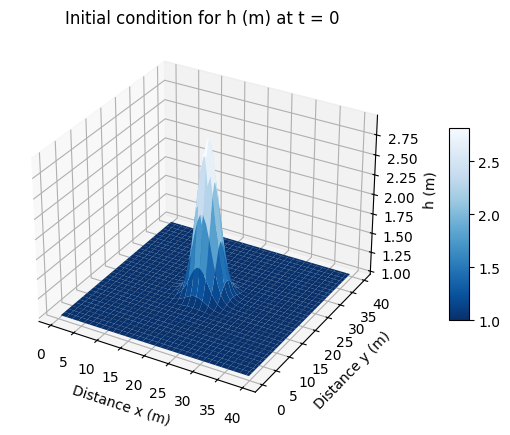

In [165]:
cmap = 'Blues_r'
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, h_all[0], cmap = cmap)
ax.set_title('Initial condition for h (m) at t = 0')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
ax.set_zlabel('h (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

if 0:
    plt.savefig('plots/2D_gauss_initial_condition.pdf', format='pdf')

plt.show()

# CNN

### Load data from h5 file

In [166]:
# Construct the file path 
file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        print(key)
    
    Q_all = f['Q_all'][:]
    t_all = f['t_all'][:]
    x = f['x'][:]
    y = f['y'][:]

print(f'Loaded Q_all with shape {Q_all.shape}')
print(f'Loaded t_all with shape {t_all.shape}')
print(f'Loaded x with shape {x.shape}')
print(f'Loaded y with shape {y.shape}')

h_all = Q_all[:, 0, :, :]

## Split the data into training and testing
p_train = 1
p_val = 0
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

Q_all
t_all
x
y
Loaded Q_all with shape (201, 3, 64, 64)
Loaded t_all with shape (201,)
Loaded x with shape (64,)
Loaded y with shape (64,)
n_train = 201, n_val = 0, n_test = 0
torch.Size([200, 64, 64]) torch.Size([200, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64])


### Prepare data 

In [167]:
# Prepare data in sequences
X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_output_train.shape

torch.Size([150, 50, 64, 64]) torch.Size([150, 64, 64])


torch.Size([150, 64, 64])

### Define model

In [168]:
# Define CNN-based model
class CNNFlowmap(nn.Module):
    def __init__(self, input_channels, spatial_steps, output_size, num_filters=64, kernel_size=3, num_layers=4):
        super(CNNFlowmap, self).__init__()
        self.conv = nn.Conv2d(input_channels, num_filters, kernel_size, padding=1)
        #self.conv2 = nn.Conv2d(batch_size, batch_size, kernel_size = 1)
        self.final_conv = nn.Conv2d(num_filters, 1, kernel_size=1)  # kernel_size=1 preserves spatial size

    def forward(self, x):
        # Input shape: [batch_size, seq_length, spatial_steps]
        x = x
        x = self.conv(x)       # Apply convolutional layers
        x = F.relu(x)          # Apply ReLU activation
        x = self.final_conv(x)
        x = x.squeeze(1)       # Remove channel dimension
        #x = self.conv2(x)
        #x = self.fc(x)         # Apply fully connected layers
        return x
    
input_channels = seq_length # seq_length
output_channels = 1
spatial_steps = Nx
output_size = 50

# Instantiate the CNN model
model = CNNFlowmap(input_channels, spatial_steps, output_size)
print(model)

CNNFlowmap(
  (conv): Conv2d(50, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (final_conv): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


### Train the model

In [169]:
learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

loss_train = []
loss_val = []

model.to(device)

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_CNN
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in dataloader_train:
        # To device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions.squeeze(), batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Average loss
    epoch_train_loss /= len(dataloader_train.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")


Epoch 0/50: Train loss = 0.230622
Epoch 10/50: Train loss = 0.001390
Epoch 20/50: Train loss = 0.000499
Epoch 30/50: Train loss = 0.000389
Epoch 40/50: Train loss = 0.001305
Training time: 39.25s


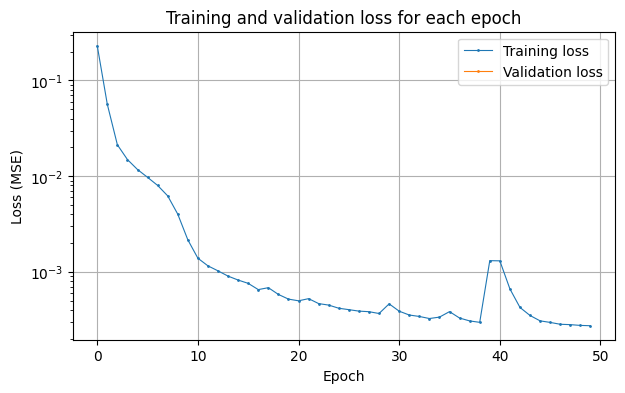

In [170]:
filename = 'plots/2D_CNN_loss.pdf'
plot_losses(loss_train, loss_val, 0, filename)

### Make predictions

In [171]:
pred_train = model(X_input_train).cpu().detach().numpy().squeeze()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train], axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

# Calculate MAE
loss_new = nn.L1Loss()
train_loss = loss_new(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

(150, 64, 64)
Train loss: 2.84e-04
Train loss: 1.12e-02


In [172]:
# Define how many time steps to predict
n_steps = n_steps_CNN

# Initialize 
current_state = X_input_train

# Store future predictions
future_predictions = []

# Predict n_steps into the future
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient tracking
    for i in range(n_steps):
        # Predict next time step
        next_state = model(current_state)
        # Add a dimension to next_state
        next_state = next_state.unsqueeze(1)

        # Store prediction
        future_predictions.append(next_state)

        # Use the predicted state as input for the next prediction
        current_state = torch.cat([current_state[:, 1:], next_state], axis=1)

        if i % 10 == 0:
            print(f"Predicted {i} steps into the future")

# Combine predictions into a single array
print(len(future_predictions))

Predicted 0 steps into the future
Predicted 10 steps into the future
Predicted 20 steps into the future
Predicted 30 steps into the future
Predicted 40 steps into the future
Predicted 50 steps into the future
Predicted 60 steps into the future
Predicted 70 steps into the future
Predicted 80 steps into the future
Predicted 90 steps into the future
Predicted 100 steps into the future
Predicted 110 steps into the future
Predicted 120 steps into the future
Predicted 130 steps into the future
Predicted 140 steps into the future
Predicted 150 steps into the future
Predicted 160 steps into the future
Predicted 170 steps into the future
Predicted 180 steps into the future
Predicted 190 steps into the future
200


### Load true solution

In [173]:
# Load data - true solution
tend = 10 
# Construct the file path 
if N_pred == 128:
    file_path = rf'C:\Users\Matteo\Documents\Speciale\Data/toro2D_N={N_pred}_t={tend}_constant_dt.h5'
else:
    file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    Q_all_true = f['Q_all'][:]
    t_all_true = f['t_all'][:]
    x_true = f['x'][:]
    y_true = f['y'][:]

print(f'Loaded Q_all with shape {Q_all_true.shape}')
print(f'Loaded t_all with shape {t_all_true.shape}')
print(f'Loaded x with shape {x_true.shape}')
print(f'Loaded y with shape {y_true.shape}')

h_all_true = Q_all_true[:, 0, :, :]
print(f'h_all_true shape: {h_all_true.shape}')

Loaded Q_all with shape (401, 3, 64, 64)
Loaded t_all with shape (401,)
Loaded x with shape (64,)
Loaded y with shape (64,)
h_all_true shape: (401, 64, 64)


### Calculate error for the long-term predictions

In [174]:
len(future_predictions)

# Calculate the loss
mse_loss_fn = nn.MSELoss()
mse_losses = []

mae_loss_fn = nn.L1Loss()
mae_losses = []

max_errors = []

for i in range(len(future_predictions)):
    # Compute MSE
    loss_mse = mse_loss_fn(future_predictions[i][-1].reshape(Nx, Nx), torch.tensor(h_all_true[i+200], dtype=torch.float32))
    mse_losses.append(loss_mse.item())

    # Compute MAE
    loss_mae = mae_loss_fn(future_predictions[i][-1].reshape(Nx, Nx), torch.tensor(h_all_true[i+200], dtype=torch.float32))
    mae_losses.append(loss_mae.item())

    # Compute max error
    max_error = torch.max(torch.abs(future_predictions[i][-1].reshape(Nx, Nx) - torch.tensor(h_all_true[i+200], dtype=torch.float32)))
    max_errors.append(max_error.item())


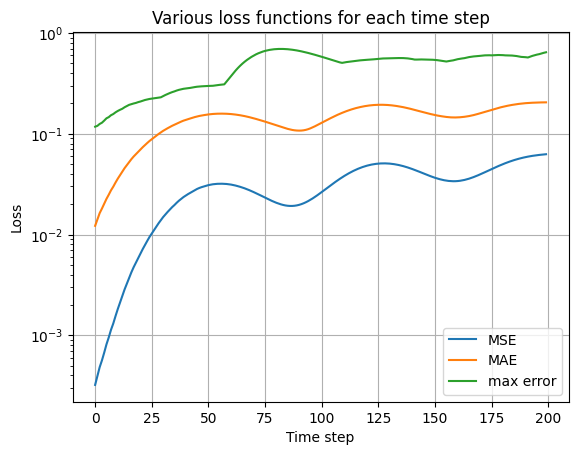

In [175]:
plt.plot(mse_losses, label='MSE')
plt.plot(mae_losses, label='MAE')
plt.plot(max_errors, label='max error')
plt.yscale('log')
plt.xlabel('Time step')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.title('Various loss functions for each time step')

if save_plots:
    plt.savefig('plots/2D_CNN_mse_mae_loss.pdf', format='pdf')
    
plt.show()


### Plot long-term predictions

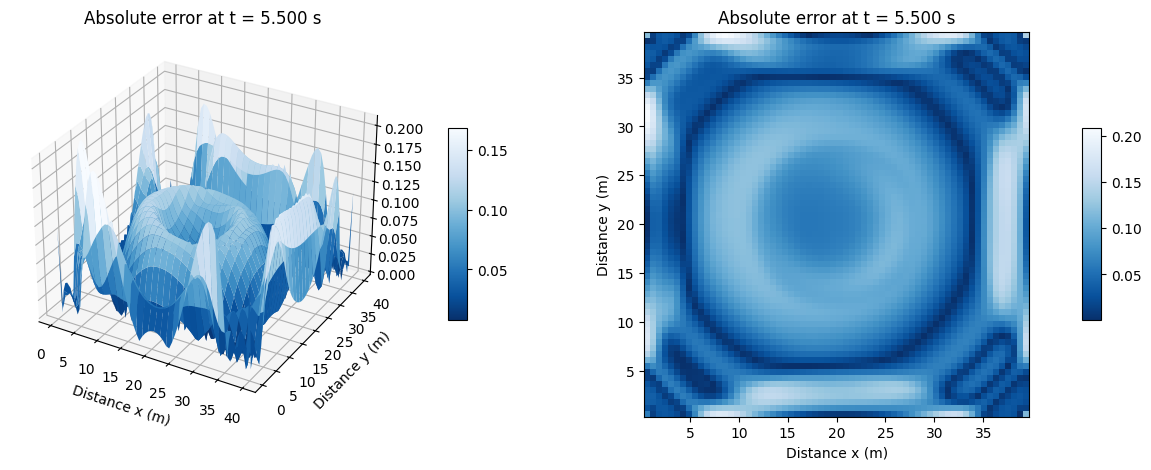

In [176]:
dt = t_all_true[1] - t_all_true[0]
X, Y = np.meshgrid(x, y)
idx = 20
idx_true = 200 + idx
cmap = 'Blues_r'

# Plot errors
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap)
ax.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122)
surf = ax1.imshow(np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap, extent=(x_true.min(), x_true.max(), y_true.min(), y_true.max()))
ax1.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig(f'plots/2D_CNN_long_term_predictions_error_Ntrain={Nx}_Npred={N_pred}_idx={idx}.pdf', format='pdf')

plt.show()

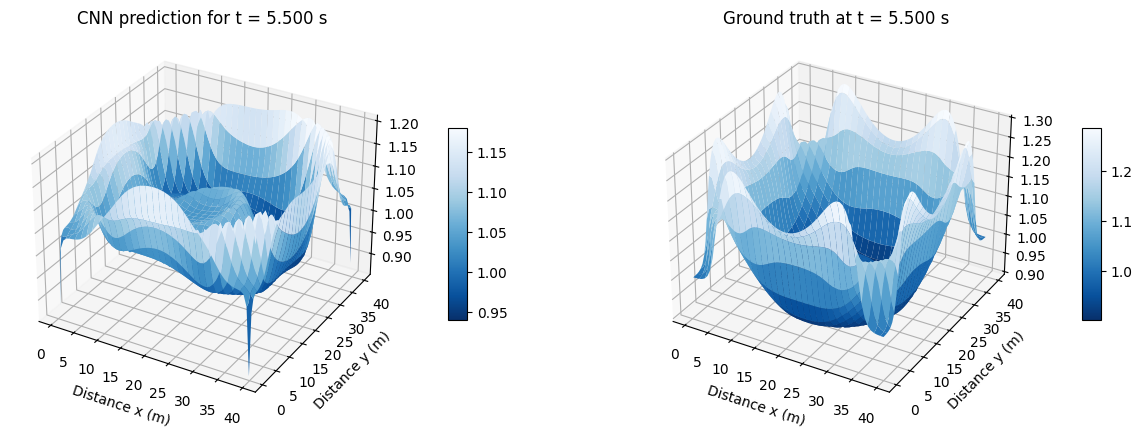

In [177]:
# Plot predictions
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, future_predictions[idx][-1].reshape(Nx, Nx), cmap=cmap)
ax.set_title(f'CNN prediction for t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122, projection='3d')
surf = ax1.plot_surface(X, Y, h_all_true[idx_true], cmap=cmap)
ax1.set_title(f'Ground truth at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig(f'plots/2D_CNN_long_term_predictions_Ntrain={Nx}_Npred={N_pred}_idx={idx}.pdf', format='pdf')

plt.show()

# FNO

### Prepare data

In [178]:
## Split the data into training and testing
p_train = 1
p_val = 0
p_test = 1 - p_train - p_val
n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

n_train = 201, n_val = 0, n_test = 0
torch.Size([200, 64, 64]) torch.Size([200, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64]) torch.Size([0, 64, 64])


In [179]:
# Prepare data in sequences
def prepare_data_sequences_2D_FNO(train_x, train_y, seq_length):
    # Fetch the dimensions of the input data
    timesteps,_ , spatial_steps_x, spatial_steps_y = train_x.shape
    #print(f"timesteps = {timesteps}, spatial_steps_x = {spatial_steps_x}, spatial_steps_y = {spatial_steps_y}")

    # Number of sequences
    n_sequences = timesteps - seq_length

    # Prepare input and target sequences
    x_seq = torch.zeros((n_sequences, seq_length, 1, spatial_steps_x, spatial_steps_y))
    y_seq = torch.zeros((n_sequences, 1, spatial_steps_x, spatial_steps_y))

    for i in range(n_sequences):
        x_seq[i] = train_x[i:i + seq_length]
        y_seq[i] = train_y[i + seq_length]
    return x_seq, y_seq

In [180]:
# Prepare data in sequences
X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
print(X_input_train.shape, X_output_train.shape)

train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

X_output_train.shape

torch.Size([150, 50, 64, 64]) torch.Size([150, 64, 64])


torch.Size([150, 64, 64])

### Define model

In [181]:
# Define model
model = TFNO(
    n_modes=(12,12), # (8,8)
    in_channels=seq_length, # seq_length
    lifting_channels=24, # 32 
    hidden_channels=24, 
    projection_channels=24, 
    out_channels=1, 
    non_linearity = torch.nn.functional.relu)

n_params = count_model_params(model)
print(f'\nThe model has {n_params} parameters.')


The model has 402681 parameters.


### Train the model

In [182]:
learn_rate = 1e-3
# Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

loss_train = []
loss_val = []

model.to(device)

# Time training
start = time.time()

# Training loop
n_epochs = n_epochs_FNO
for epoch in range(n_epochs):
    model.train() # Set model to training mode
    epoch_train_loss = 0

    for batch_X, batch_y in dataloader_train:
        # To device
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions = model(batch_X)
        loss = loss_fn(predictions.squeeze(), batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_train_loss += loss.item() * batch_X.size(0) # Accumulate loss

    # Average loss
    epoch_train_loss /= len(dataloader_train.dataset)

    # Save losses
    loss_train.append(epoch_train_loss)

    # Print losses
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{n_epochs}: Train loss = {epoch_train_loss:.6f}")

# Time training
end = time.time()
training_time = end - start
print(f"Training time: {training_time:.2f}s")

Epoch 0/50: Train loss = 0.422962
Epoch 10/50: Train loss = 0.008006
Epoch 20/50: Train loss = 0.004974
Epoch 30/50: Train loss = 0.001783
Epoch 40/50: Train loss = 0.000493
Training time: 118.94s


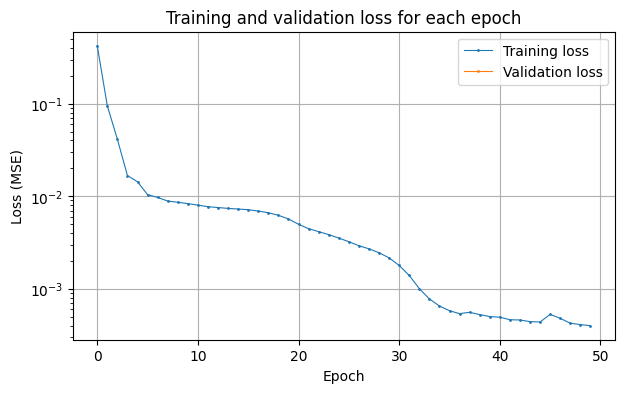

In [183]:
filename = 'plots/2D_FNO_loss.pdf'
plot_losses(loss_train, loss_val, 0, filename)

### Make predictions

In [184]:
pred_train = model(X_input_train).cpu().detach().numpy().squeeze()

# Combine pred_train, pred_val and pred_test
pred_all = np.concatenate([pred_train], axis=0)
print(pred_all.shape)

# Compute loss
train_loss = loss_fn(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

# Calculate MAE
loss_new = nn.L1Loss()
train_loss = loss_new(torch.tensor(pred_train), X_output_train).item()
print(f"Train loss: {train_loss:.2e}")

(150, 64, 64)
Train loss: 4.12e-04
Train loss: 1.36e-02


In [185]:
# Define how many time steps to predict
n_steps = n_steps_FNO # 50

# Initialize 
current_state = X_input_train

# Store future predictions
future_predictions = []

# Predict n_steps into the future
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient tracking
    for i in range(n_steps):
        # Predict next time step
        next_state = model(current_state)

        # Store prediction
        future_predictions.append(next_state)

        # Use the predicted state as input for the next prediction
        current_state = torch.cat([current_state[:, 1:], next_state], axis=1)

        if i % 10 == 0:
            print(f"Predicted {i} steps into the future")

# Combine predictions into a single array
print(len(future_predictions))

Predicted 0 steps into the future
Predicted 10 steps into the future
Predicted 20 steps into the future
Predicted 30 steps into the future
Predicted 40 steps into the future
Predicted 50 steps into the future
Predicted 60 steps into the future
Predicted 70 steps into the future
Predicted 80 steps into the future
Predicted 90 steps into the future
Predicted 100 steps into the future
Predicted 110 steps into the future
Predicted 120 steps into the future
Predicted 130 steps into the future
Predicted 140 steps into the future
Predicted 150 steps into the future
Predicted 160 steps into the future
Predicted 170 steps into the future
Predicted 180 steps into the future
Predicted 190 steps into the future
200


### Make predictions for another grid size (a finer grid)

In [186]:
tend = 10

if N_pred > Nx:
    print('Making predictions for a finer grid')
    # Construct the file path 
    if N_pred == 128:
        file_path = rf'C:\Users\Matteo\Documents\Speciale\Data/toro2D_N={N_pred}_t={tend}_constant_dt.h5'

    # Load the data
    with h5py.File(file_path, 'r') as f:
        for key in f.keys():
            print(key)
        
        Q_all = f['Q_all'][:]
        t_all = f['t_all'][:]
        x = f['x'][:]
        y = f['y'][:]

    print(f'Loaded Q_all with shape {Q_all.shape}')
    print(f'Loaded t_all with shape {t_all.shape}')
    print(f'Loaded x with shape {x.shape}')
    print(f'Loaded y with shape {y.shape}')

    h_all = Q_all[:, 0, :, :]

    ## Split the data into training and testing
    p_train = 0.6
    p_val = 0.2
    p_test = 1 - p_train - p_val
    n_train, n_val, n_test, a, u, n, train_x, train_y, val_x, val_y, test_x, test_y = prepare_data_2D(h_all, p_train, p_val)

    # Prepare data in sequences
    X_input_train, X_output_train = prepare_data_sequences_2D(train_x, train_y, seq_length)
    print(X_input_train.shape, X_output_train.shape)

    train_dataset = torch.utils.data.TensorDataset(X_input_train, X_output_train)
    dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    X_output_train.shape

    pred_train = model(X_input_train).cpu().detach().numpy().squeeze()
    pred_all = np.concatenate([pred_train], axis=0)
    print(pred_all.shape)

    # Define how many time steps to predict
    n_steps = 20

    # Initialize 
    #current_state = torch.tensor(u, dtype=torch.float32)
    current_state = X_input_train

    # Store future predictions
    future_predictions = []

    # Predict n_steps into the future
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient tracking
        for i in range(n_steps):
            # Predict next time step
            next_state = model(current_state)

            # Store prediction
            future_predictions.append(next_state)

            # Use the predicted state as input for the next prediction
            current_state = torch.cat([current_state[:, 1:], next_state], axis=1)

            if i % 10 == 0:
                print(f"Predicted {i} steps into the future")

    # Combine predictions into a single array
    print(len(future_predictions))

### Load true solution

In [187]:
# Load data - true solution
tend = 10 
# Construct the file path 
if N_pred == 128:
    file_path = rf'C:\Users\Matteo\Documents\Speciale\Data/toro2D_N={N_pred}_t={tend}_constant_dt.h5'
else:
    file_path = rf'C:\Users\Matteo\Shallow-Water-Equations\dataFNO/toro2D_N={Nx}_t={tend}_constant_dt.h5'

# Load the data
with h5py.File(file_path, 'r') as f:
    Q_all_true = f['Q_all'][:]
    t_all_true = f['t_all'][:]
    x_true = f['x'][:]
    y_true = f['y'][:]

print(f'Loaded Q_all with shape {Q_all_true.shape}')
print(f'Loaded t_all with shape {t_all_true.shape}')
print(f'Loaded x with shape {x_true.shape}')
print(f'Loaded y with shape {y_true.shape}')

h_all_true = Q_all_true[:, 0, :, :]
print(f'h_all_true shape: {h_all_true.shape}')

Loaded Q_all with shape (401, 3, 64, 64)
Loaded t_all with shape (401,)
Loaded x with shape (64,)
Loaded y with shape (64,)
h_all_true shape: (401, 64, 64)


### Calculate error for the long-term predictions

In [188]:
len(future_predictions)

# Calculate the loss
mse_loss_fn = nn.MSELoss()
mse_losses = []

mae_loss_fn = nn.L1Loss()
mae_losses = []

max_errors = []

for i in range(len(future_predictions)):
    # Compute MSE
    loss_mse = mse_loss_fn(future_predictions[i][-1].reshape(Nx, Nx), torch.tensor(h_all_true[i+200], dtype=torch.float32))
    mse_losses.append(loss_mse.item())

    # Compute MAE
    loss_mae = mae_loss_fn(future_predictions[i][-1].reshape(Nx, Nx), torch.tensor(h_all_true[i+200], dtype=torch.float32))
    mae_losses.append(loss_mae.item())

    # Compute max error
    max_error = torch.max(torch.abs(future_predictions[i][-1].reshape(Nx, Nx) - torch.tensor(h_all_true[i+200], dtype=torch.float32)))
    max_errors.append(max_error.item())


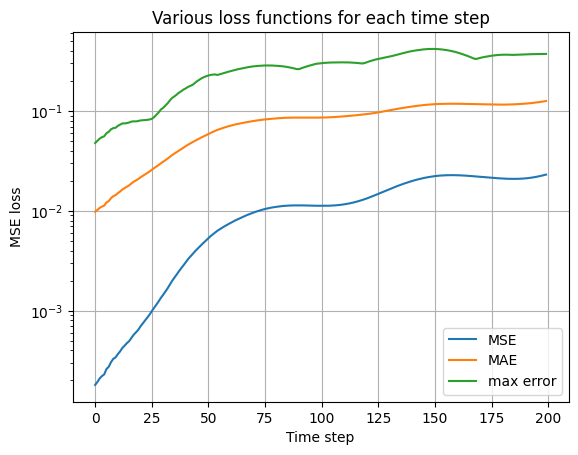

In [189]:
plt.plot(mse_losses, label='MSE')
plt.plot(mae_losses, label='MAE')
plt.plot(max_errors, label='max error')
plt.yscale('log')
plt.xlabel('Time step')
plt.ylabel('MSE loss')
plt.legend()
plt.grid()
plt.title('Various loss functions for each time step')

if save_plots:
    plt.savefig('plots/2D_FNO_mse_mae_loss.pdf', format='pdf')
    
plt.show()


### Plot predictions

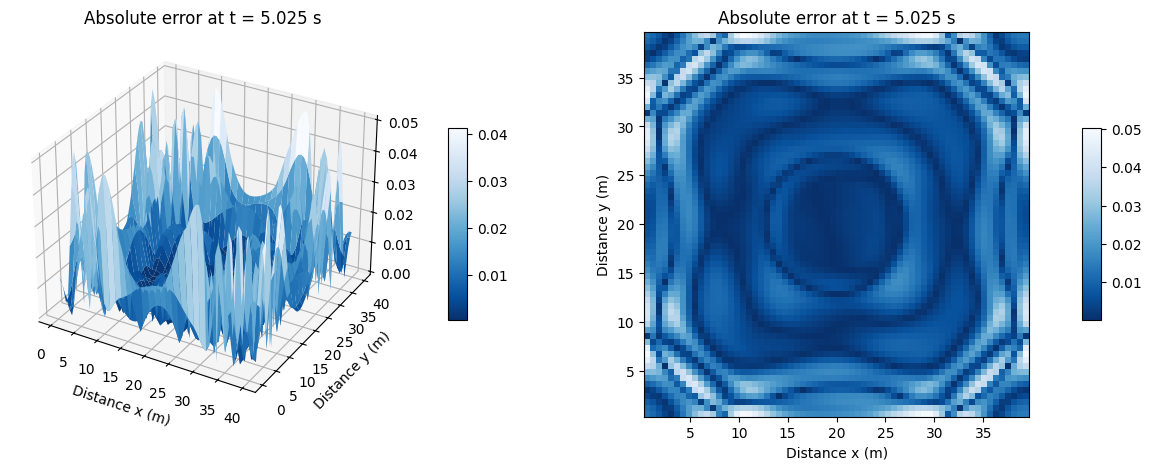

In [190]:
dt = t_all_true[1] - t_all_true[0]
X, Y = np.meshgrid(x, y)
idx = 1
idx_true = 200 + idx
cmap = 'Blues_r'

# Plot errors
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap)
ax.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122)
surf = ax1.imshow(np.abs(h_all_true[idx_true] - future_predictions[idx][-1].reshape(Nx, Nx).detach().numpy()), cmap=cmap, extent=(x_true.min(), x_true.max(), y_true.min(), y_true.max()))
ax1.set_title(f'Absolute error at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig(f'plots/2D_FNO_long_term_predictions_error_Ntrain={Nx}_Npred={N_pred}_idx={idx}.pdf', format='pdf')

plt.show()

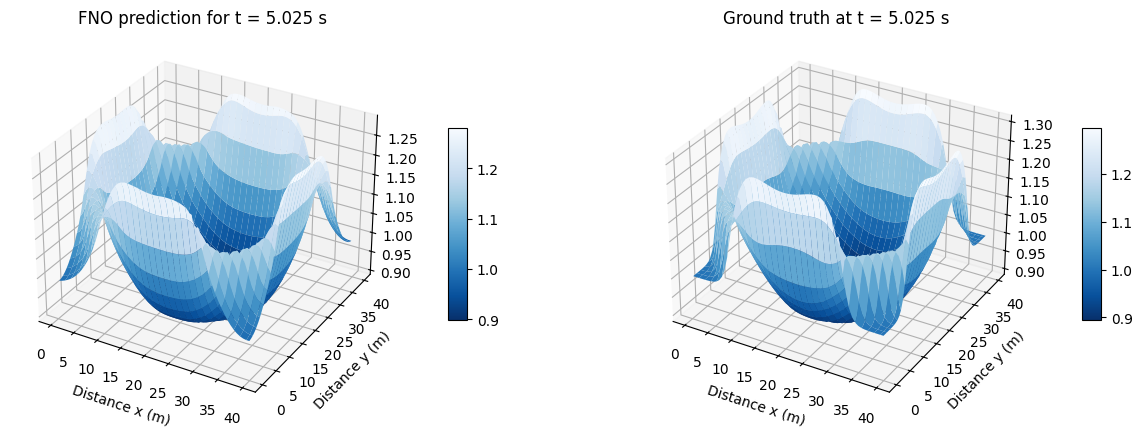

In [191]:
# Plot predictions
fig = plt.figure(figsize=(15, 5))

ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, Y, future_predictions[idx][-1].reshape(Nx, Nx), cmap=cmap)
ax.set_title(f'FNO prediction for t = {t_all_true[idx_true]:.3f} s')
ax.set_xlabel('Distance x (m)')
ax.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.1)

ax1 = fig.add_subplot(122, projection='3d')
surf = ax1.plot_surface(X, Y, h_all_true[idx_true], cmap=cmap)
ax1.set_title(f'Ground truth at t = {t_all_true[idx_true]:.3f} s')
ax1.set_xlabel('Distance x (m)')
ax1.set_ylabel('Distance y (m)')
plt.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, pad=0.1)

if save_plots:
    plt.savefig(f'plots/2D_FNO_long_term_predictions_Ntrain={Nx}_Npred={N_pred}_idx={idx}.pdf', format='pdf')

plt.show()